<h1>Predicting Gender from Foursquare Attributes</h1>
<h2>MS&E 234</h2>

<h3>Setup</h3>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Download Dingqi Yang's 'User Profile Dataset' and 'Global-scale Check-in Dataset with User Social Networks' [here](https://sites.google.com/site/yangdingqi/home/foursquare-dataset) and place them in this directory.

In [13]:
# User Profile Paths
import os
os.getcwd()

'/Users/julietdaniel/Documents/GitHub/foursquare-gender-prediction'

In [15]:
os.chdir('/Users/julietdaniel/Documents/foursquare-gender-prediction-local')
user_profile_dir = 'dataset_UbiComp2016/'
profile_data = 'dataset_UbiComp2016_UserProfile_NYC.txt'

### Preprocessing

The following functions parse user profile and check-in data. The functions returns the gender and check-ins for each user.

In [16]:
def parse_genders(filename):
    """ Parse user profile dataset for gender.
        
        Parameters:
        - filename = path to user profile dataset
        Returns:
        - genders = dataframe containing gender for each user
    """
    def convert_gender(series):
        return int(series == 'male')
    
    genders = pd.read_csv(filename, usecols=[0, 1], delimiter='\t', header=None, converters={1: convert_gender}, names=['User_ID', 'Gender'])
    return genders

genders = parse_genders(user_profile_dir + profile_data)

**IMPORTANT**: Before running the next cell, run (NOTEBOOK) to generate the check-in dataset.

In [18]:
# Check-In Data
check_ins = pd.read_csv('gender-checkins-complete.csv', delimiter='\t')

### Exploration

Let's take a look at our check-in data.

In [19]:
check_ins.head()

,Unnamed: 0,User_ID,Venue_ID,UTC_Time,Timezone_Offset,Lat,Long,Category,Country_Code
0,0,21939,4dd53b151f6ec4e0bb8c0480,Tue Apr 03 18:00:49 +0000 2012,-240,39.285600,-76.612047,Clothing Store,US
1,1,163646,4b70040ff964a52080032de3,Tue Apr 03 18:01:31 +0000 2012,-240,25.716845,-80.281378,College Cafeteria,US
2,2,256534,4b29929cf964a5200fa124e3,Tue Apr 03 18:01:37 +0000 2012,-360,40.726135,-111.852087,American Restaurant,US
3,3,176836,4b66f88ff964a520eb322be3,Tue Apr 03 18:01:40 +0000 2012,-300,29.661129,-95.115077,Community College,US
4,4,181560,4bc7086715a7ef3bef9878da,Tue Apr 03 18:02:41 +0000 2012,-240,40.745164,-73.982519,Medical Center,US


As we can see, most users have relatively few check-ins.

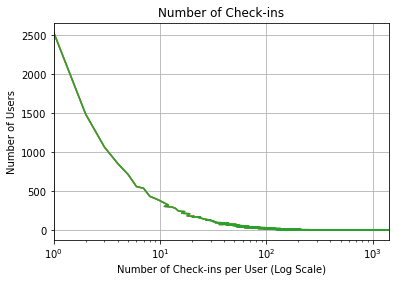

In [22]:
counts = check_ins['User_ID'].value_counts().value_counts()
ax = counts.plot(title='Number of Check-ins', grid=True, logx=True)
ax.set_xlabel('Number of Check-ins per User (Log Scale)')
ax.set_ylabel('Number of Users')
plt.show()

### Prediction

We now predict gender based on check-ins.

#### Data Split

In [9]:
def split_y(genders, split, seed):
    """ Split gender data into train and test sets.
        
        Parameters:
        - genders = gender dataset
        - split = percentage from 0 to 1 of training data
        Returns:
        - train, test splits
    """
    genders = genders.sample(frac=1, random_state=seed)
    split = int(split * genders.shape[0])
    train = genders[:split]
    test = genders[split:]
    return train, test

y_train, y_test = split_y(genders, 0.7, 0)

In [15]:
X_train = check_ins[check_ins['User_ID'].isin(y_train['User_ID'])]
X_test = check_ins[check_ins['User_ID'].isin(y_test['User_ID'])]

#### Model